# Lab 8

Registration No.: 2348542

Name: Purusharth Malik

## Importing the dataset and getting first impressions

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_palette('viridis')
warnings.filterwarnings('ignore')

In [4]:
#importing the dataset
df = pd.read_csv('spam.csv', encoding='latin-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
#cleaning the dataset
df = df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"],axis=1)
df.columns = ['label', 'text']

In [ ]:
df.head()

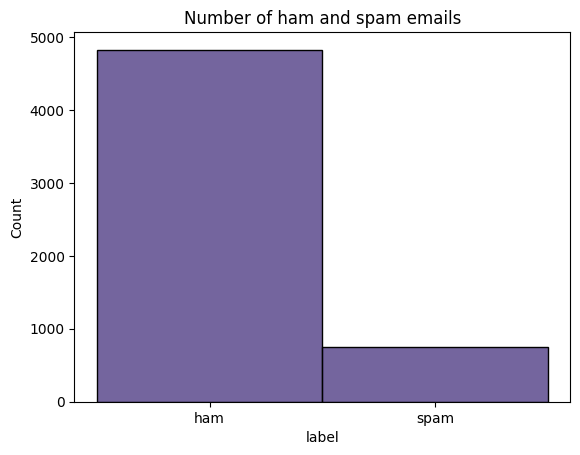

In [8]:
sns.histplot(df.label)
plt.title('Number of ham and spam emails')
plt.show()

Clearly, there is huge class imbalance in the given dataset.

In [9]:
df.label.value_counts(normalize=True)

label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

Clearly, the stratification works perfectly.

## Feature Engineering

In [10]:
#removing stop words
from sklearn.feature_extraction import text

f = text.CountVectorizer(stop_words='english')
X = f.fit_transform(df['text'])
X

<5572x8404 sparse matrix of type '<class 'numpy.int64'>'
	with 43478 stored elements in Compressed Sparse Row format>

In this sparse matrix, 1 appears wherever the stop word `j` appears in the text `i`.

In [11]:
y = df.label.apply(lambda x:0 if x=='ham' else 1)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   stratify=y,
                                                   test_size=0.2,
                                                   random_state=42)

In [13]:
#let's see if stratification worked or not
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(label
 0    0.865829
 1    0.134171
 Name: proportion, dtype: float64,
 label
 0    0.866368
 1    0.133632
 Name: proportion, dtype: float64)

## Naive Bayes

In [46]:
from sklearn.naive_bayes import MultinomialNB

#the default Laplace smoothing parameter is alpha=1
nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

In [49]:
from sklearn.metrics import confusion_matrix, fbeta_score

confusion_matrix(y_test, y_pred)

array([[952,  14],
       [  7, 142]], dtype=int64)

Since this is a spam filtering model, we want to focus more on the false positives which is why our chosen metric for evaluation will be F-beta score with beta<1 (for maximizing precision).

In [50]:
fbeta_score(y_test, y_pred, beta=0)

0.9102564102564102

## Hyperparameter Tuning

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

nb=MultinomialNB()
grid = GridSearchCV(estimator=nb,
                    param_grid={'alpha':np.arange(0, 20, 0.1)},
                    scoring=make_scorer(fbeta_score, beta=0),
                    cv=10,
                    verbose=0)

grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=MultinomialNB(),
             param_grid={'alpha': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7....
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2, 15.3,
       15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16. , 16.1, 16.2, 16.3, 16.4,
       16.5, 16.6, 16.7, 16.8, 16.9, 17. , 17.1, 17.2, 17.3, 17.4, 17.5,
       17.6, 17.7, 17.8, 17.9, 18. , 18.1, 18.2, 18.3, 18.4, 18.5, 18.6,
       18.7, 18.8, 18.9, 19. , 19.1, 19.2, 19.3, 19.4, 19.5, 19.6, 19.7,
       19.8, 19.9])},
             scoring=make_scorer(fbeta_score, beta=0))

In [63]:
grid.best_params_

{'alpha': 19.900000000000002}

In [64]:
#training naive bayes with best_params_
nb_best = MultinomialNB(alpha=19.9)

nb_best.fit(X_train, y_train)

y_pred_best = nb_best.predict(X_test)

In [65]:
fbeta_score(y_test, y_pred_best, beta=0)

1.0

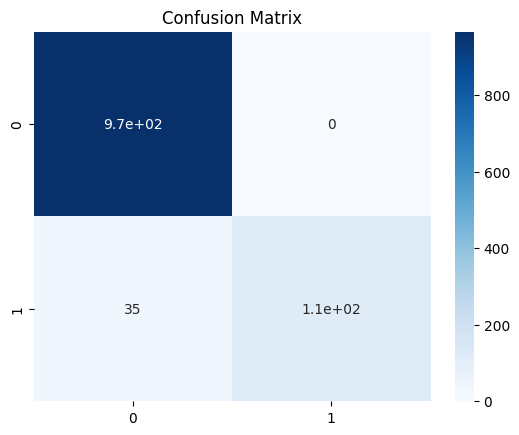

In [77]:
sns.heatmap(confusion_matrix(y_test, y_pred_best),
            annot=True,
            cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

We have eliminated the false positives.

## Plotting the ROC Curve

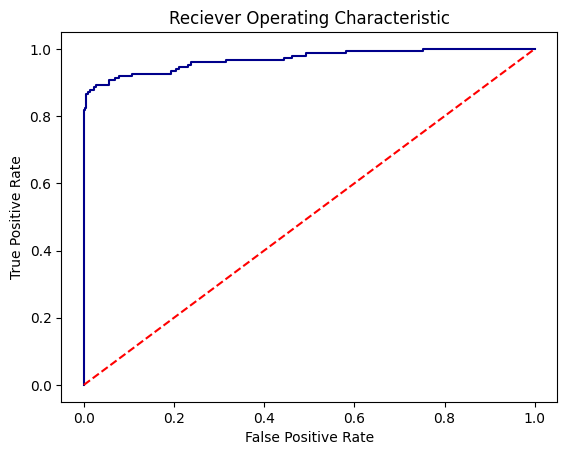

In [113]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, threshold = roc_curve(y_test, nb_best.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, color='#00008B')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reciever Operating Characteristic')
plt.show()

From the ROC curve, we can find the threshold that minimizes the False Positive Rate and maximizes the True Positive Rate.

## Plotting the Precision-Recall Curve

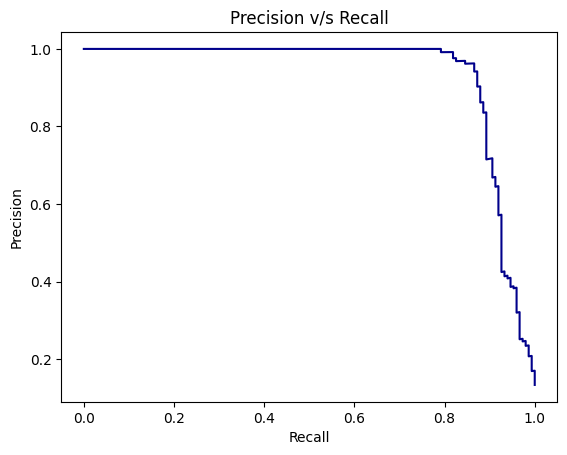

In [125]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_test, nb_best.predict_proba(X_test)[:,1])
plt.plot(recall, precision, color='#00008B')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision v/s Recall')
plt.show()

For email spam detection, we have seen previously that our motive is to maximize precision.

## Feature Importance Graph

In [149]:
#getting the feature names
feature_names = f.get_feature_names_out()
feature_names

array(['00', '000', '000pes', ..., 'ûïharry', 'ûò', 'ûówell'],
      dtype=object)

In [165]:
#making a dictionary of words with feature importances
feature_dict = dict(zip(feature_names, nb_best.feature_log_prob_[1]))

In [172]:
#getting the top 20 features
top_twenty = sorted(feature_dict.items(), key=lambda x: x[1], reverse=True)[:20]
top_twenty

[('free', -6.784592867929279),
 ('txt', -7.052625996500617),
 ('ur', -7.155881324636377),
 ('stop', -7.329682359089928),
 ('text', -7.329682359089928),
 ('claim', -7.347089238982496),
 ('mobile', -7.391980079496719),
 ('reply', -7.429402594033382),
 ('www', -7.46828018207607),
 ('prize', -7.617652077164287),
 ('cash', -7.6409360161183315),
 ('uk', -7.664775047294384),
 ('won', -7.689196285371187),
 ('just', -7.7142288815838045),
 ('new', -7.766256218912459),
 ('send', -7.766256218912459),
 ('150p', -7.779697281481477),
 ('win', -7.793321470421021),
 ('urgent', -7.807133844708632),
 ('nokia', -7.821139675897552)]

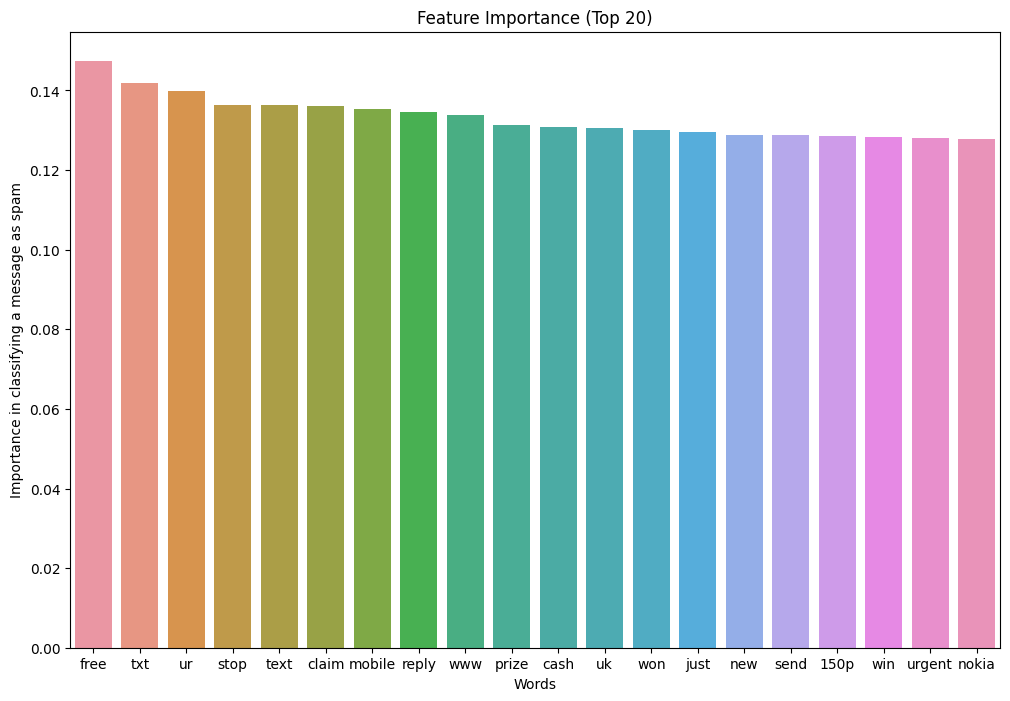

In [189]:
#plotting the important features
plt.figure(figsize=(12, 8))
sns.barplot(y=[1/np.abs(i[1]) for i in top_twenty], x=[i[0] for i in top_twenty])
plt.xlabel('Words')
plt.ylabel('Importance in classifying a message as spam')
plt.title('Feature Importance (Top 20)')
plt.show()

## Model Evaluation Metrics

In [211]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

metrics = [
    accuracy_score(y_test, y_pred_best),
    precision_score(y_test, y_pred_best),
    recall_score(y_test, y_pred_best),
    roc_auc_score(y_test, y_pred_best)
]

metrics_it = iter(metrics)
metric_names = ['accuracy', 'precision', 'recall', 'roc_auc']

for _ in metric_names:
    print(f'For the given dataset, the {_} score using the trained model is {next(metrics_it)}')

For the given dataset, the accuracy score using the trained model is 0.968609865470852
For the given dataset, the precision score using the trained model is 1.0
For the given dataset, the recall score using the trained model is 0.7651006711409396
For the given dataset, the roc_auc score using the trained model is 0.8825503355704698


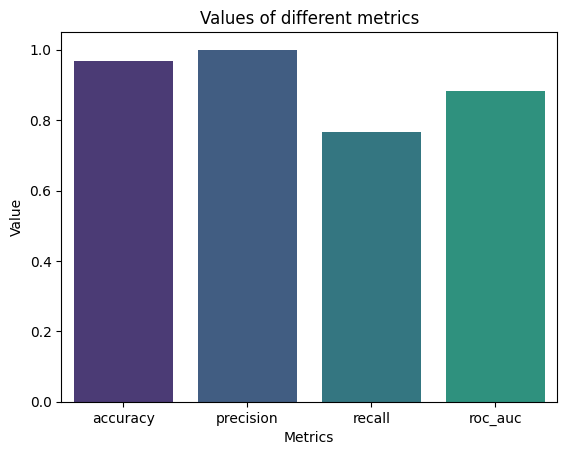

In [218]:
#plotting the same
sns.set_palette('viridis')
sns.barplot(y=metrics, x=metric_names)
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Values of different metrics')
plt.show()

## Threshold Selection Graph